## imports

In [1]:
import pandas as pd
import numpy as np
# from helpers import *
import lightgbm as lgb
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict, MutableMapping
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

C:\Users\Gheorghe\Anaconda3\envs\basic\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


In [2]:
def load_data(file, train=True, clean=False):
    f = open(file, mode='r', encoding='utf8', newline='\n')
    offset = int(train)
    x, y = [], []
    for l in f:
        tokens = l[:-1].split(',')
        x.append(tokens[offset:])
        if train:
            y.append(tokens[0])
#             if len(tokens) > 3:

#             else:
#                 print(tokens)
    f.close()
    return x, y

dex_race = {'Protoss':1, 'Zerg':2, 'Terran':3}
dex_key = {'s':4, 'Base':5, 'SingleMineral':6,
        'hotkey00':100,'hotkey01':101,'hotkey02':102,
        'hotkey10':10,'hotkey11':11,'hotkey12':12,
        'hotkey20':20,'hotkey21':21,'hotkey22':22,
        'hotkey30':30,'hotkey31':31,'hotkey32':32,
        'hotkey40':40,'hotkey41':41,'hotkey42':42,
        'hotkey50':50,'hotkey51':51,'hotkey52':52,
        'hotkey60':60,'hotkey61':61,'hotkey62':62,
        'hotkey70':70,'hotkey71':71,'hotkey72':72,
        'hotkey80':80,'hotkey81':81,'hotkey82':82,
        'hotkey90':90,'hotkey91':91,'hotkey92':92,}

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        try:
            new_key = parent_key + sep + str(k) if parent_key else k
        except:
            print(parent_key)
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def transform_X(x, max_time, max_act, time_window, split_time):
    X = {}
    for i,l in enumerate(x):
        features = {'hotkey'+str(i):0 for i in range(10)}
        new_l = []
        firsts = 0
        last = 0
        features[l[0]] = 1
        for j in range(1,len(l)):
            t = l[j]
            if t[0] == 't':
                last = int(t[1:])
                if last % time_window == 0 and last <= split_time:
                    counter = Counter(new_l)
                    features[t] = counter
                    new_l = []
                if last == max_time:
                    break
            elif t in dex_key:
                new_l.append(t)
                if 'hotkey' in t:
                    features[t[:-1]] += 1
                if firsts < max_act:
                    features['act_'+str(firsts)] = dex_key[t]
                    firsts += 1
        
        features.update(Counter(new_l))
        features['duration'] = last
        
        X[i] = flatten(features)
    
    return X

def form_cols(max_act, time_window, split_time):
    
    cols = ['Protoss', 'Zerg', 'Terran', 'duration']
    hot_keys = ['hotkey'+str(x) for x in range(0,10)]
    cols.extend(hot_keys)

    actions = dex_key.keys()
    for t in range(time_window, split_time+1,time_window):
        for c in actions:
            cols.append('t'+str(t)+'_'+c)
    
    for c in actions:
            cols.append(c)
        
    cat_cols = ['race']    
    for i in range(max_act):
        cols.append('act_'+str(i))
        cat_cols.append('act_'+str(i))

    return cols, cat_cols

def create_df(x, max_time=7000, max_act=0, time_window=5, split_time=20):
    X = transform_X(x, max_time, max_act, time_window, split_time)
    cols, _ = form_cols(max_act, time_window, split_time)
#     print(cols)
    df = pd.DataFrame.from_dict(X, orient='index', columns=cols)
    df.sort_index(inplace=True)
    df.fillna(0,inplace=True)
    
    return df



## load data

In [3]:
# parameters
max_act = 10
max_time = 7000
time_window = 30
split_time = 30

In [4]:
x,y = load_data('TRAIN.CSV')
print(len(x), len(y))

3052 3052


In [5]:
df = create_df(x, max_time=max_time, max_act=max_act, time_window=time_window, split_time=split_time)
df.shape

(3052, 90)

In [6]:
pd.set_option('display.max_columns', 999)
df.head()

,Protoss,Zerg,Terran,duration,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,hotkey6,hotkey7,hotkey8,hotkey9,t30_s,t30_Base,t30_SingleMineral,t30_hotkey00,t30_hotkey01,t30_hotkey02,t30_hotkey10,t30_hotkey11,t30_hotkey12,t30_hotkey20,t30_hotkey21,t30_hotkey22,t30_hotkey30,t30_hotkey31,t30_hotkey32,t30_hotkey40,t30_hotkey41,t30_hotkey42,t30_hotkey50,t30_hotkey51,t30_hotkey52,t30_hotkey60,t30_hotkey61,t30_hotkey62,t30_hotkey70,t30_hotkey71,t30_hotkey72,t30_hotkey80,t30_hotkey81,t30_hotkey82,t30_hotkey90,t30_hotkey91,t30_hotkey92,s,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,hotkey22,hotkey30,hotkey31,hotkey32,hotkey40,hotkey41,hotkey42,hotkey50,hotkey51,hotkey52,hotkey60,hotkey61,hotkey62,hotkey70,hotkey71,hotkey72,hotkey80,hotkey81,hotkey82,hotkey90,hotkey91,hotkey92,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9
0,1.0,0.0,0.0,1655,46,413,222,402,260,118,21,1,0,4,6.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,668.0,64.0,5.0,4.0,0.0,41.0,63.0,0.0,350.0,37.0,0.0,185.0,0.0,0.0,401.0,5.0,0.0,255.0,4.0,0.0,114.0,3.0,0.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,30.0,100.0
1,1.0,0.0,0.0,1655,85,516,230,349,311,0,0,0,17,19,25.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,513.0,9.0,0.0,2.0,0.0,83.0,65.0,3.0,448.0,15.0,0.0,215.0,6.0,0.0,324.0,3.0,0.0,308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,1.0,0.0,18.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,4.0,30.0
2,1.0,0.0,0.0,1010,21,147,135,321,137,91,12,0,0,4,17.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,413.0,45.0,3.0,2.0,0.0,18.0,17.0,0.0,130.0,9.0,0.0,126.0,0.0,0.0,308.0,7.0,0.0,130.0,3.0,0.0,88.0,1.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,5.0,4.0,4.0,4.0,5.0,4.0,30.0,100.0,4.0,32.0
3,1.0,0.0,0.0,1005,41,292,84,251,287,0,0,0,0,15,19.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,378.0,18.0,0.0,2.0,0.0,39.0,32.0,1.0,259.0,14.0,0.0,70.0,5.0,0.0,232.0,3.0,0.0,284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,30.0
4,1.0,0.0,0.0,540,1,62,44,201,86,15,0,0,0,0,13.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,52.0,6.0,0.0,38.0,0.0,0.0,191.0,2.0,0.0,84.0,1.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,5.0,4.0,30.0,100.0,4.0,32.0


### Encode labels

In [7]:
y_set = set(y)
dex_player = {}
dex_label = {}
for i,p in enumerate(y_set):
    dex_player[p] = i
    dex_label[i] = p
    
Y = [dex_player[p] for p in y]
nY = np.array(Y)
nY.shape

(3052,)

## Models

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df, nY, test_size=0.33, random_state=42)

### Decision tree

In [9]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
dt_pred = clf.predict(X_test)
f1_score(y_test, dt_pred, average='micro')

0.7420634920634921

### Logistic Regression

In [10]:
lr_clf = LogisticRegression(random_state=0, solver='liblinear', multi_class='auto', max_iter=2000)
lr_clf.fit(X_train,y_train)

lr_pred = lr_clf.predict(X_test)
f1_score(y_test, lr_pred, average='micro')

0.8392857142857143

### Random Forest

In [56]:
rf_clf = RandomForestClassifier(random_state=17, n_estimators=500)
rf_clf.fit(X_train,y_train)
rf_pred = rf_clf.predict(X_test)
print(f1_score(y_test, rf_pred, average='micro'))

0.9513888888888888


### Light GBM

In [13]:
X_train, X_val, y_train, y_val = train_test_split(df, nY, test_size=0.33, random_state=42)
_, cat_cols = form_cols(max_act, time_window, split_time)

train_data = lgb.Dataset(X_train, label=y_train,
                         feature_name=list(X_train), 
#                          categorical_feature=cat_cols
                        )
validation_data = lgb.Dataset(X_val, label=y_val, reference=train_data,
                              feature_name=list(X_train), 
#                               categorical_feature=cat_cols
                             )

In [14]:
param = param = {'num_leaves': 255,
                 'objective': 'multiclass',
                 'min_data_in_leaf': 1,
                 'num_class':200,
                 'learning_rate':0.02}
num_round = 1000
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data],
                verbose_eval=100, early_stopping_rounds=30)

Training until validation scores don't improve for 30 rounds
[100]	valid_0's multi_logloss: 1.85094
[200]	valid_0's multi_logloss: 1.58695
[300]	valid_0's multi_logloss: 1.49076
[400]	valid_0's multi_logloss: 1.42002
[500]	valid_0's multi_logloss: 1.36259
[600]	valid_0's multi_logloss: 1.31973
[700]	valid_0's multi_logloss: 1.30899
Early stopping, best iteration is:
[721]	valid_0's multi_logloss: 1.30887


Overall accuracy of model: 0.8134920634920635 ; f_score:  0.8134920634920635


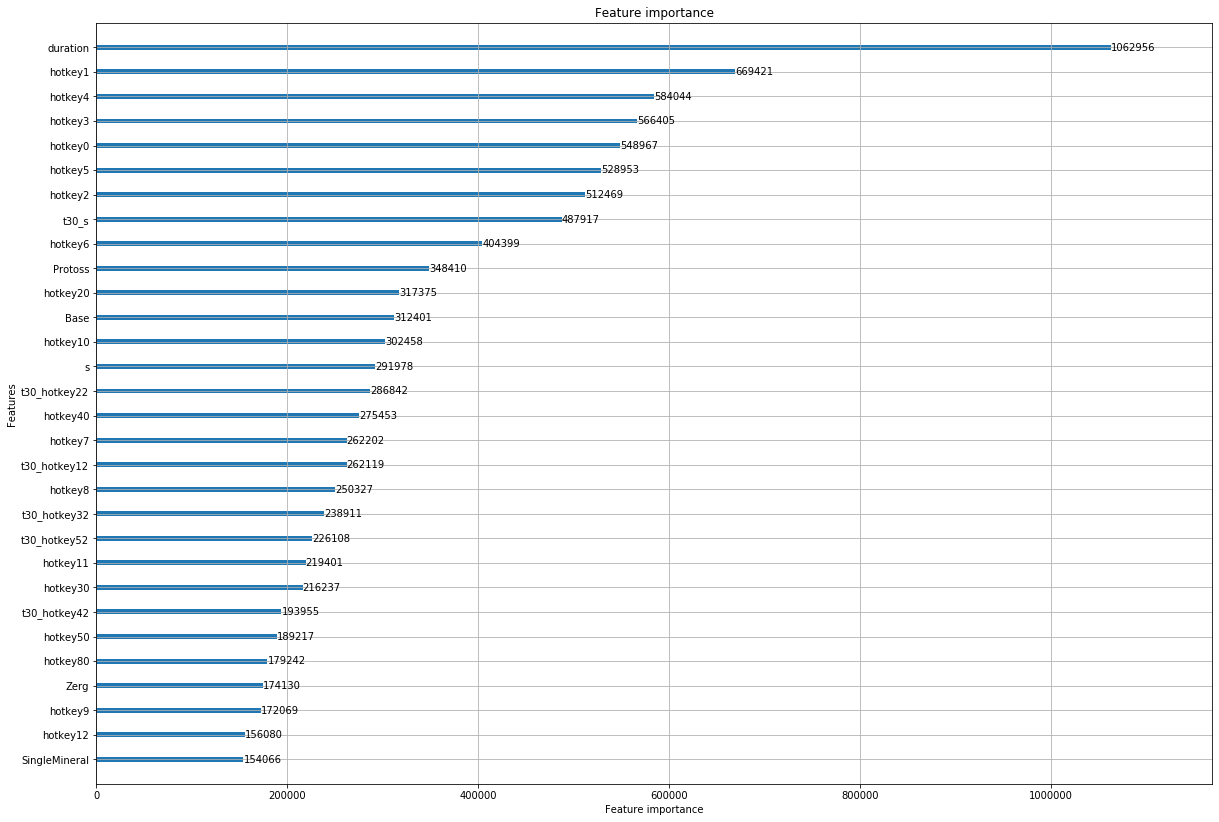

In [15]:
predictions_prob = bst.predict(X_val, num_iteration=bst.best_iteration)    
predictions_lgb = np.argmax(predictions_prob, axis=1)
#Print accuracy
acc_lgbm = accuracy_score(y_val,predictions_lgb)
f_score_lgbm = f1_score(y_val,predictions_lgb,average='micro')
print('Overall accuracy of model:', acc_lgbm,'; f_score: ',f_score_lgbm)
ax = lgb.plot_importance(bst, figsize=(20,14), importance_type='split',
                         max_num_features=30)
plt.show()

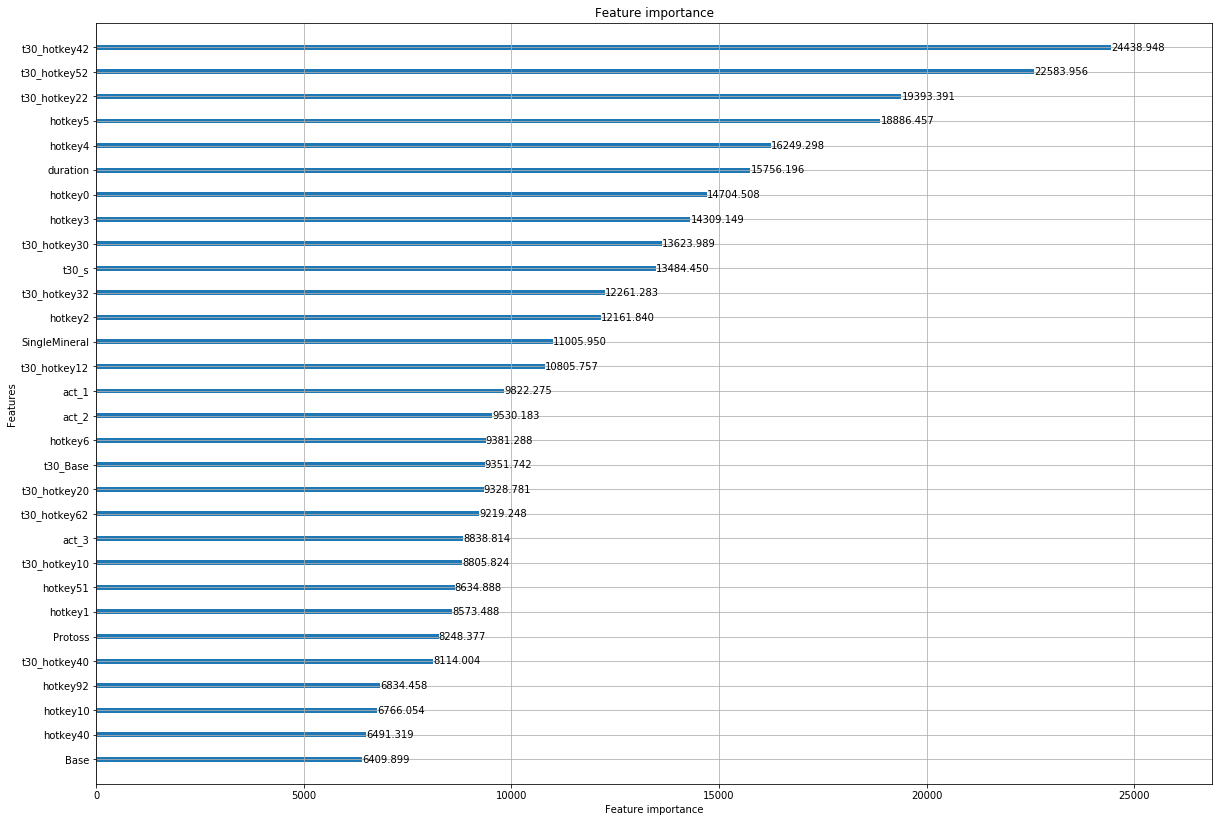

In [16]:
ax = lgb.plot_importance(bst, figsize=(20,14), importance_type='gain',
                         max_num_features=30)
plt.show()

## Predict

In [17]:
def write_pred_file(name, pred):
    sub = open(name, mode='w', encoding='utf8')
    sub.write('RowId,prediction\n')
    for i,l in enumerate(test_prediction):
        sub.writelines(f'{i+1},{dex_label[l]}\n')
    sub.close()

In [18]:
# load test data
x_test,_ = load_data('TEST.CSV',train=False)
X_test = create_df(x_test, max_time=max_time, max_act=max_act, time_window=time_window, split_time=split_time)

In [19]:
# train on all data
rf_clf.fit(df,nY)
# predict on test
test_prediction = rf_clf.predict(X_test)
write_pred_file('SUBMISSION_RF_03.CSV', test_prediction)

In [20]:
# bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data],
#                 verbose_eval=100, early_stopping_rounds=30)
predictions_prob = bst.predict(X_test, num_iteration=bst.best_iteration)    
predictions_lgb = np.argmax(predictions_prob, axis=1)
write_pred_file('SUBMISSION_GBM_01.CSV', test_prediction)

## Data Exploration

In [8]:
sorted_y = sorted(Counter(y).items(), key=lambda kv: kv[1])
sorted_dict = OrderedDict(sorted_y)
sorted_y[:5],sorted_y[-5:]

([('http://kr.battle.net/sc2/en/profile/3488858/1/EGJD/', 4),
  ('http://us.battle.net/sc2/en/profile/4580957/1/iGJim/', 4),
  ('http://kr.battle.net/sc2/en/profile/4529934/1/SpiderCheck/', 4),
  ('http://kr.battle.net/sc2/en/profile/4324250/1/Kane/', 4),
  ('http://us.battle.net/sc2/en/profile/1640778/1/Guitarcheese/', 4)],
 [('http://kr.battle.net/sc2/en/profile/2332264/1/Zest/', 42),
  ('http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/', 44),
  ('http://kr.battle.net/sc2/en/profile/2341467/1/Classic/', 50),
  ('http://kr.battle.net/sc2/en/profile/2342419/1/soO/', 51),
  ('http://kr.battle.net/sc2/en/profile/2348639/1/ParalyzE/', 58)])

Samples for each players in dataset varies between 58 and 4

Traces per race. More games on Protoss. (better patch for this race)

In [9]:
print(df[df['Protoss'] == 1]['Protoss'].count())
print(df[df['Zerg'] == 1]['Zerg'].count())
print(df[df['Terran'] == 1]['Terran'].count())

1210
1061
781


In [10]:
cols, _ = form_cols(max_act, time_window, split_time)

In [11]:
df['label'] = nY

In [12]:
player_games = []
for player in y:
    player_games.append(sorted_dict[player])
df['player_games'] = player_games

In [13]:
df.head()

,Protoss,Zerg,Terran,duration,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,hotkey6,hotkey7,hotkey8,hotkey9,t30_s,t30_Base,t30_SingleMineral,t30_hotkey00,t30_hotkey01,t30_hotkey02,t30_hotkey10,t30_hotkey11,t30_hotkey12,t30_hotkey20,t30_hotkey21,t30_hotkey22,t30_hotkey30,t30_hotkey31,t30_hotkey32,t30_hotkey40,t30_hotkey41,t30_hotkey42,t30_hotkey50,t30_hotkey51,t30_hotkey52,t30_hotkey60,t30_hotkey61,t30_hotkey62,t30_hotkey70,t30_hotkey71,t30_hotkey72,t30_hotkey80,t30_hotkey81,t30_hotkey82,t30_hotkey90,t30_hotkey91,t30_hotkey92,s,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,hotkey22,hotkey30,hotkey31,hotkey32,hotkey40,hotkey41,hotkey42,hotkey50,hotkey51,hotkey52,hotkey60,hotkey61,hotkey62,hotkey70,hotkey71,hotkey72,hotkey80,hotkey81,hotkey82,hotkey90,hotkey91,hotkey92,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,label,player_games
0,1.0,0.0,0.0,1655,46,413,222,402,260,118,21,1,0,4,6.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,668.0,64.0,5.0,4.0,0.0,41.0,63.0,0.0,350.0,37.0,0.0,185.0,0.0,0.0,401.0,5.0,0.0,255.0,4.0,0.0,114.0,3.0,0.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,30.0,100.0,106,15
1,1.0,0.0,0.0,1655,85,516,230,349,311,0,0,0,17,19,25.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,513.0,9.0,0.0,2.0,0.0,83.0,65.0,3.0,448.0,15.0,0.0,215.0,6.0,0.0,324.0,3.0,0.0,308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,1.0,0.0,18.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,4.0,30.0,128,37
2,1.0,0.0,0.0,1010,21,147,135,321,137,91,12,0,0,4,17.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,413.0,45.0,3.0,2.0,0.0,18.0,17.0,0.0,130.0,9.0,0.0,126.0,0.0,0.0,308.0,7.0,0.0,130.0,3.0,0.0,88.0,1.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,5.0,4.0,4.0,4.0,5.0,4.0,30.0,100.0,4.0,32.0,106,15
3,1.0,0.0,0.0,1005,41,292,84,251,287,0,0,0,0,15,19.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,378.0,18.0,0.0,2.0,0.0,39.0,32.0,1.0,259.0,14.0,0.0,70.0,5.0,0.0,232.0,3.0,0.0,284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,30.0,128,37
4,1.0,0.0,0.0,540,1,62,44,201,86,15,0,0,0,0,13.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,52.0,6.0,0.0,38.0,0.0,0.0,191.0,2.0,0.0,84.0,1.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,5.0,4.0,30.0,100.0,4.0,32.0,106,15


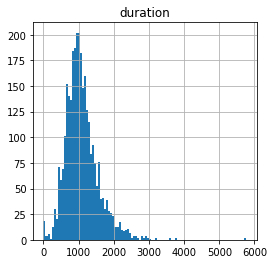

In [14]:
df.hist(column='duration',bins=100,figsize=(4,4))
plt.show()

In [17]:
df['duration'].describe()

count    3052.000000
mean     1088.463303
std       475.836941
min         0.000000
25%       785.000000
50%      1020.000000
75%      1310.000000
max      5770.000000
Name: duration, dtype: float64

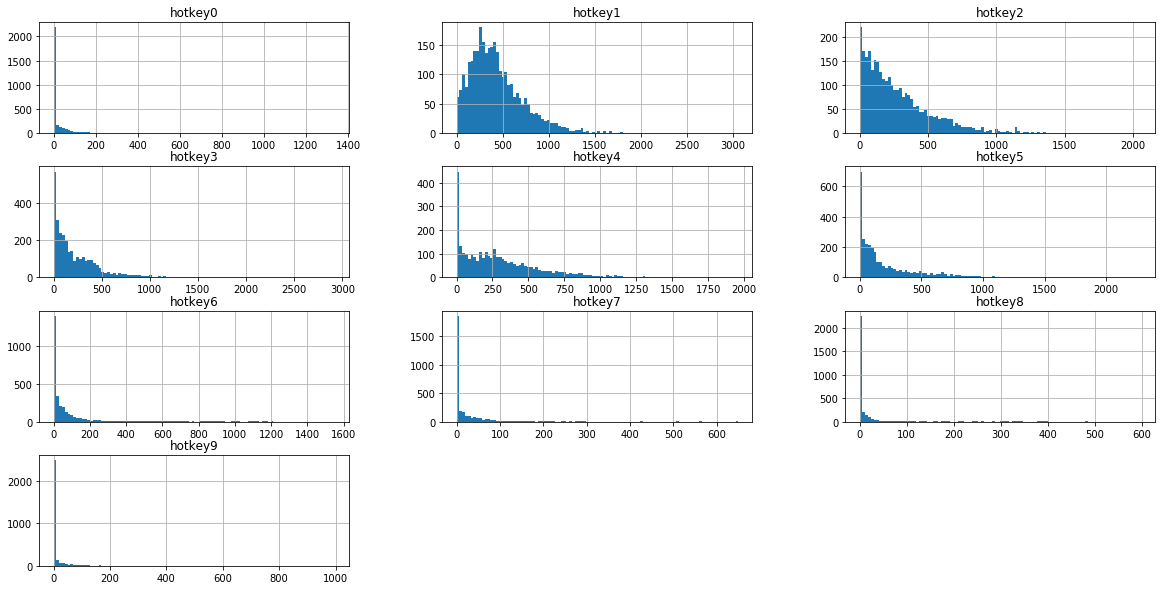

In [15]:
df.hist(column=cols[4:14],bins=100,figsize=(20,10))
plt.show()

Get games of players with 30+ games

In [49]:
grouped = df.loc[df['player_games'] >= 40].groupby('label')
sampled_df = grouped.apply(lambda x: x.sample(n=10))
lb = np.array(sampled_df['label'])
print(len(sampled_df['label'].unique()))
sampled_df = sampled_df[cols[:-10]]
sampled_df.shape

6


(60, 80)

In [50]:
# lb

In [51]:
data = sampled_df.values

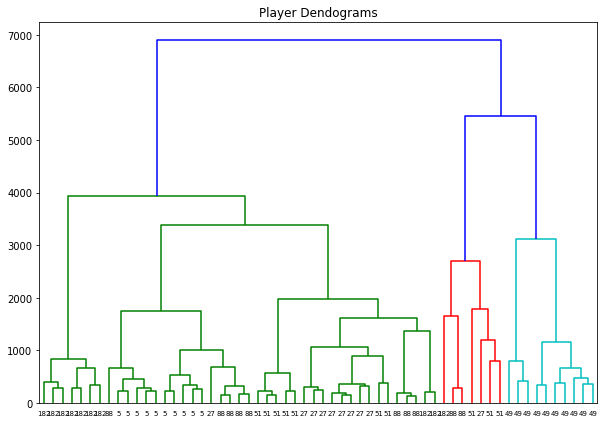

In [54]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Player Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'),labels=lb,
                      leaf_font_size=7,
                      leaf_rotation=0,
                     )

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
cm = confusion_matrix(y_test, rf_pred)

In [61]:
for i in range(0, cm.shape[0]):
    row = cm[i, :]
    sm = sum(row)
    if sm != 0:
        cm[i, :] = row / sm

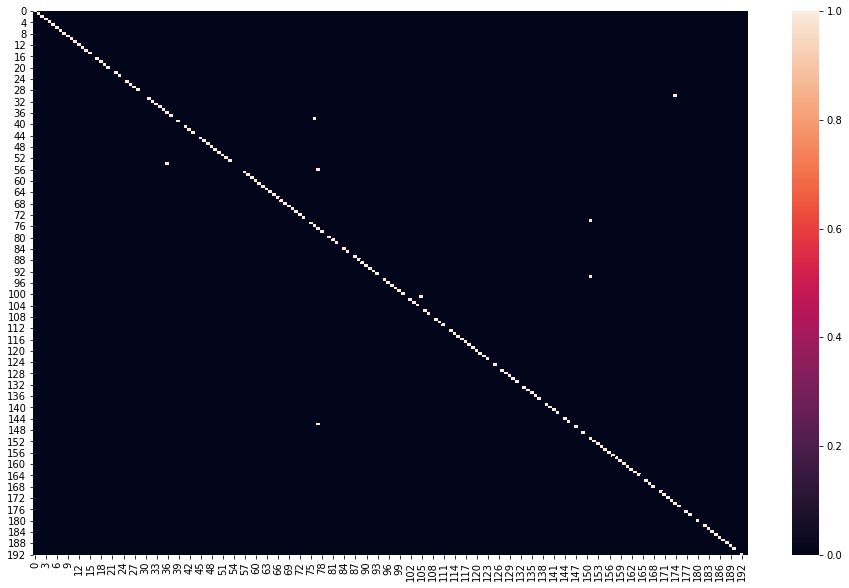

In [62]:
fig= plt.figure(figsize=(16,10))
sb.heatmap(cm)